# River Flood based on GloFAS Discharge Data

This tutorial will guide through the process of computing flood foodprints from GloFAS river discharge data and using these footprints in CLIMADA impact calculations.

Executing this tutorial requires access to the Copernicus Data Store (CDS) and the input data for the flood footprint pipeline.
Please have a look at the documentation of the [GloFAS River Flood module](../glofas_rf.rst) and follow the instructions in its "Preparation" section before continuing.

The first step is setting up the "static" data required for the river flood model.
The `setup_all` function will download the flood hazard maps, the FLOPROS flood protection database, and the pre-computed Gumbel distribution fit parameters.
This might take a while.

In [1]:
from climada.util import log_level
from climada_petals.hazard.rf_glofas import setup_all

with log_level("DEBUG", "climada_petals"):
    setup_all()


2023-11-15 11:22:08,379 - climada_petals.hazard.rf_glofas.setup - DEBUG - No flood maps found. Downloading GeoTIFF files to /Users/ldr.riedel/climada/data/river-flood-computation/flood-maps
2023-11-15 11:22:08,380 - climada_petals.hazard.rf_glofas.setup - DEBUG - Downloading flood hazard maps
2023-11-15 11:29:04,400 - climada_petals.hazard.rf_glofas.setup - DEBUG - Merging flood hazard maps into single dataset
2023-11-15 11:35:30,169 - climada_petals.hazard.rf_glofas.setup - DEBUG - Downloading FLOPROS database
2023-11-15 11:35:31,777 - climada_petals.hazard.rf_glofas.setup - DEBUG - Downloading Gumbel fit parameters


In [2]:
from climada_petals.hazard.rf_glofas import RiverFloodInundation

countries = ["Germany", "Switzerland", "Austria"]

rf = RiverFloodInundation()
rf.download_forecast(
    countries=countries,
    forecast_date="2021-07-10",
    preprocess=lambda x: x.max(dim="step"),
    system_version="operational",  # Version mislabeled
)

ds_flood = rf.compute()
ds_flood


2023-11-15 11:19:19,792 - climada_petals.hazard.rf_glofas.transform_ops - DEBUG - Preparing download directory: /Users/ldr.riedel/climada/data/cds-download
2023-11-15 11:19:19,793 - climada_petals.hazard.rf_glofas.transform_ops - DEBUG - Choosing lat/lon bounds from countries ['Germany', 'Switzerland', 'Austria']
2023-11-15 11:19:23,777 - climada_petals.util.cds_glofas_downloader - INFO - Downloading file: /Users/ldr.riedel/climada/data/cds-download/glofas-forecast-ensemble-2021-07-10.grib


2023-11-15 11:19:23,928 INFO Welcome to the CDS
2023-11-15 11:19:23,928 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/cems-glofas-forecast
2023-11-15 11:19:24,054 INFO Request is queued
2023-11-15 11:19:32,399 INFO Request is running
2023-11-15 11:20:13,894 INFO Request is completed
2023-11-15 11:20:13,894 INFO Downloading https://download-0017.copernicus-climate.eu/cache-compute-0017/cache/data1/adaptor.mars.external-1700043570.3072197-32204-12-077f47ce-49aa-42e2-afd7-c4f7507df267.grib to /Users/ldr.riedel/climada/data/cds-download/glofas-forecast-ensemble-2021-07-10.grib (7.5M)
2023-11-15 11:20:16,520 INFO Download rate 2.9M/s   
Ignoring index file '/Users/ldr.riedel/climada/data/cds-download/glofas-forecast-ensemble-2021-07-10.grib.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:              (number: 50, longitude: 1356, latitude: 1128)
Coordinates:
  * number               (number) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
    time                 datetime64[ns] ...
    surface              float64 ...
    step                 timedelta64[ns] ...
  * longitude            (longitude) float64 5.854 5.863 5.871 ... 17.14 17.15
  * latitude             (latitude) float64 55.15 55.14 55.13 ... 45.76 45.75
Data variables:
    flood_depth          (latitude, longitude, number) float32 dask.array<chunksize=(762, 162, 50), meta=np.ndarray>
    flood_depth_flopros  (latitude, longitude, number) float32 dask.array<chunksize=(762, 162, 50), meta=np.ndarray>

The returned dataset contains two variables, `flood_depth` and `flood_depth_flopros` which indicate the flood footprints without and with FLOPROS protection levels considered, respectively.
Notice that intermediate data is stored in a cache directory by default, but the returned flood data is not.
You can use {py:func}`~climada_petals.hazard.rf_glofas.transform_ops.save_file` to store it.
The cache directory will be deleted as soon as the `RiverFloodInundation` object is.

In [2]:
from climada_petals.hazard.rf_glofas import save_file

save_file(ds_flood, "flood-2021-07-10.nc")


To use the data within CLIMADA we will have to "translate" it into a Hazard object.
We provide a helper function for that: {py:func}`~climada_petals.hazard.rf_glofas.rf_glofas.hazard_series_from_dataset`.
Here we have to specify the variable to be read as hazard intensity (we choose the one *without* FLOPROS protection levels) and the dimension of the dataset that indicates the "event" dimension of the Hazard object.
If the dataset contained more dimensions than `event_dim`, `latitude` and `longitude`, the function `hazard_series_from_dataset` would return a pandas Series of Hazard objects indexed with these additional dimensions.
We will see this later.

Notice that storing data and reading it from a file might in some cases be faster than loading the data directly into a Hazard object, because the latter requires some potentially costly transpositions of the underlying data structures.

<GeoAxes: title={'center': 'RF max intensity at each point'}>

/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/pyth

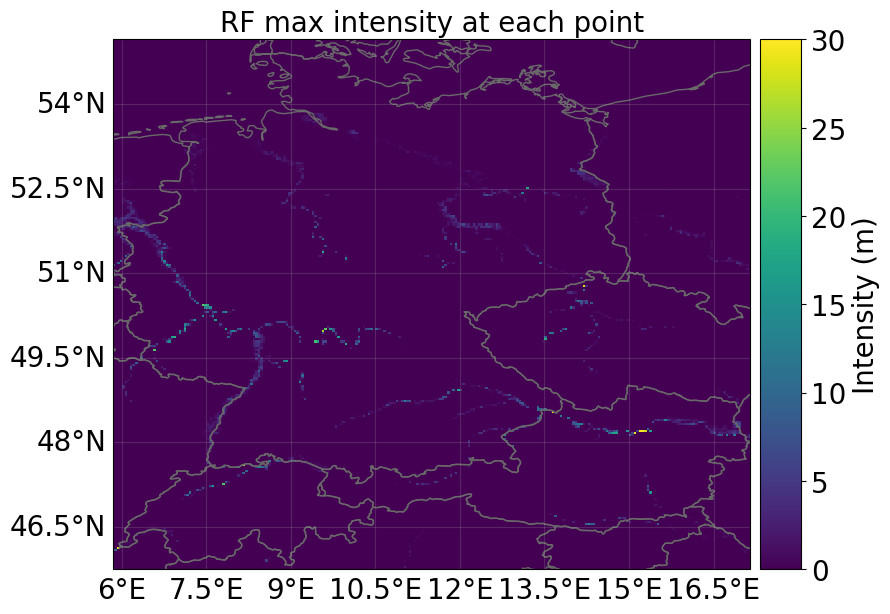

In [3]:
from climada_petals.hazard.rf_glofas import hazard_series_from_dataset

hazard = hazard_series_from_dataset(
    ds_flood, intensity="flood_depth", event_dim="number"
)
hazard.plot_intensity(event=0)


## Exposure and Vulnerability

When looking at flood warnings and protection we typically want to determine how many people might be affected from floods or lose their homes.
We therefore use data on population distribution as exposure.
To that end, we create a `LitPop` exposure with the `pop` mode for the countries of interest.

Being affected by a flood can be considered a binary classification (yes/no), therefore we use a simple step function with a relatively low threshold of 0.2 m.

Notice that we set the impact function identifier to `"RF"` because this is the hazard type identifier of `RiverFlood`.

In [4]:
from climada.entity import LitPop
from climada.entity import ImpactFunc, ImpactFuncSet

# Create a population exposure
exposure = LitPop.from_countries(["Germany", "Switzerland", "Austria"], fin_mode="pop")
exposure.gdf["impf_RF"] = 1

# Create a impact function for being affected by flooding
impf_affected = ImpactFunc.from_step_impf(
    intensity=(0.0, 0.2, 100.0), impf_id=1, haz_type="RF"
)
impf_set_affected = ImpactFuncSet([impf_affected])


2023-11-14 13:04:25,425 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: DEU (276)...

2023-11-14 13:04:25,470 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2023-11-14 13:04:25,470 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2023-11-14 13:04:25,484 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2023-11-14 13:04:25,485 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2023-11-14 13:04:25,497 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2023-11-14 13:04:25,498 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2023-11-14 13:04:25,510 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Usi

## Impact Calculation

We simply plug everything together and calculate the impact.
Afterwards, we plot the impact for 14 July 2021.

2023-11-14 13:04:31,816 - climada.entity.exposures.base - INFO - Matching 876313 exposures with 1529568 centroids.


2023-11-14 13:04:31,910 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-11-14 13:04:34,183 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.


<GeoAxes: title={'center': 'Expected annual impact'}>

/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/pyth

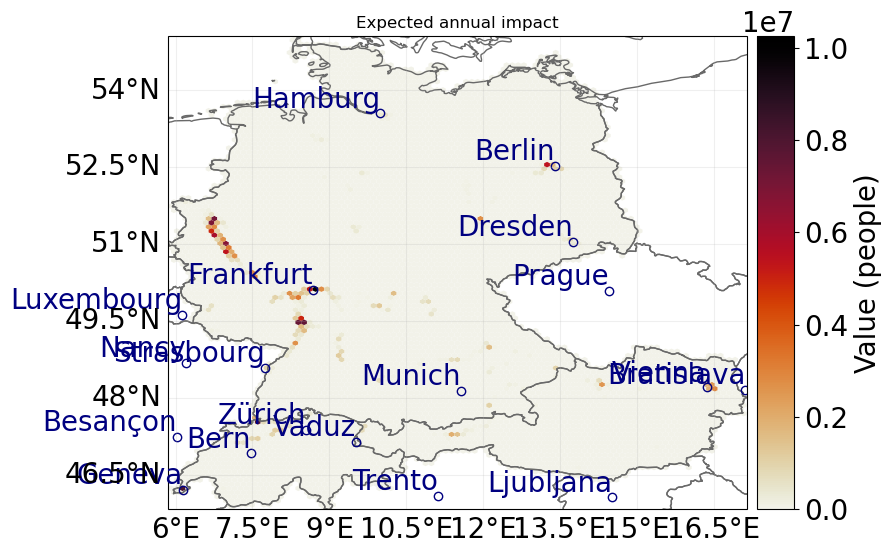

In [5]:
from climada.engine import ImpactCalc

impact = ImpactCalc(exposure, impf_set_affected, hazard).impact()
impact.plot_hexbin_eai_exposure(gridsize=100, lw=0)


## FLOPROS Database Protection Standards

So far, we ignored any protection standards, likely overestimating the impact of events.
The FLOPROS database provides information on river flood protection standards.
It is a supplement to the publication by [P. Scussolini et al.: "FLOPROS: an evolving global database of flood protection standards"](https://dx.doi.org/10.5194/nhess-16-1049-2016)
It was automatically loaded when you called `setup_all()`.

Let's compare the hazard and corresponding impacts when considering the FLOPROS protection standards!

<GeoAxes: title={'center': 'RF max intensity at each point'}>

/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/pyth

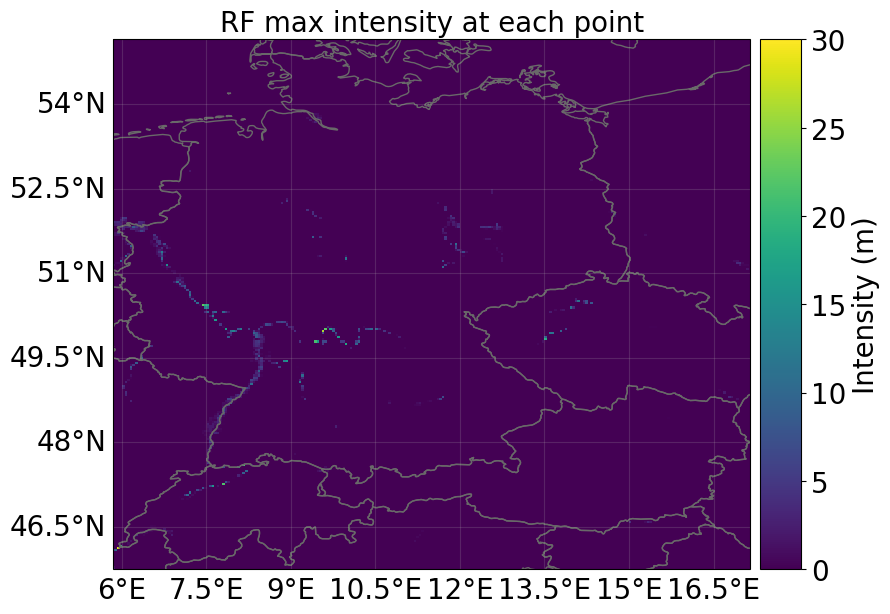

In [6]:
hazard_flopros = hazard_series_from_dataset(
    ds_flood, intensity="flood_depth_flopros", event_dim="number"
)
hazard_flopros.plot_intensity(event=0)


2023-11-14 13:06:14,507 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2023-11-14 13:06:14,507 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2023-11-14 13:06:14,508 - climada.entity.exposures.base - INFO - Matching 876313 exposures with 1529568 centroids.
2023-11-14 13:06:14,560 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-11-14 13:06:16,401 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.


<GeoAxes: title={'center': 'Expected annual impact'}>

/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/pyth

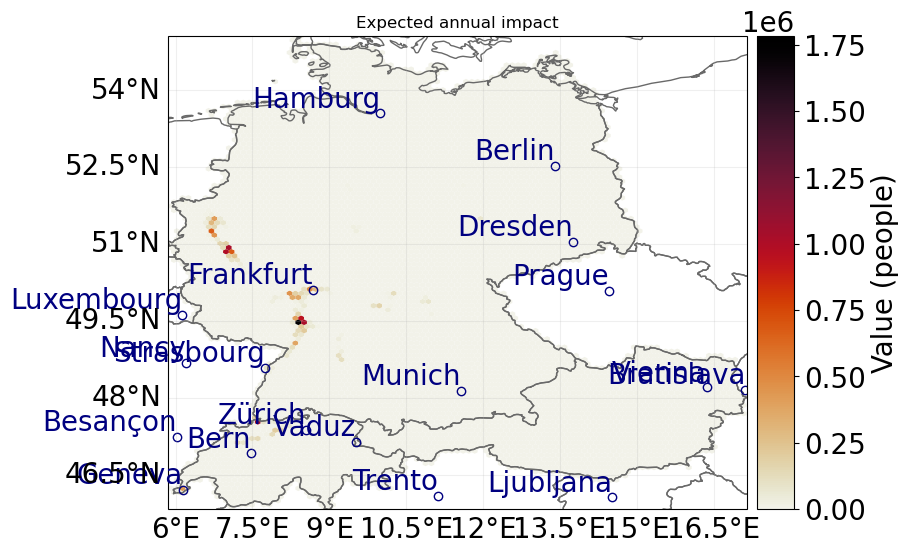

In [7]:
impact_flopros = ImpactCalc(exposure, impf_set_affected, hazard_flopros).impact()
impact_flopros.plot_hexbin_eai_exposure(gridsize=100, lw=0)


Text(0.02, 0.5, 'Affected Population')

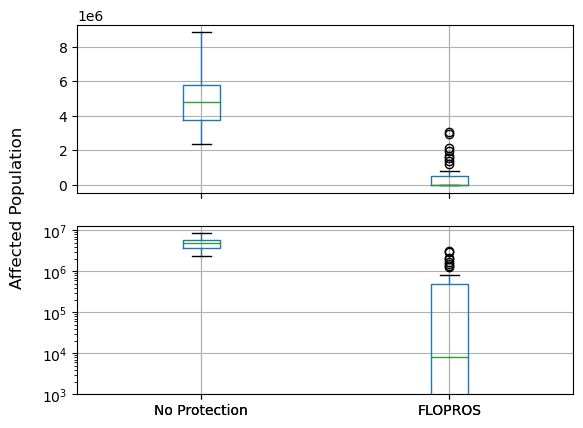

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

df_impact = pd.DataFrame.from_dict(
    data={"No Protection": impact.at_event, "FLOPROS": impact_flopros.at_event}
)

fig, axes = plt.subplots(2, 1, sharex=True)

for ax in axes:
    df_impact.boxplot(ax=ax)

axes[1].set_yscale("log")
axes[1].set_ylim(bottom=1e3)
fig.supylabel("Affected Population")


## Multidimensional Data

We computed the risk of population being affected by 0.2 m of river flooding from the forecast issued on 2021-07-10 over the next 10 days.
We reduced the dimensionality of the data by simply taking the maximum discharge over the lead time of 10 days before computing the flood footprint.
We can get a clearer picture of flood timings by defining sub-selection of the lead time and computing footprints for each of these.
This is easy to do because we receive the downloaded discharge as xarray DataArray and can manipulate it however we like before putting it into the computation pipeline.
However, increasing the amount of flood footprints to compute will also increase the computational cost.

In [9]:
discharge = rf.download_forecast(
    countries=countries,
    forecast_date="2021-07-10",
    system_version="operational",  # Version mislabeled
)
discharge


Ignoring index file '/Users/ldr.riedel/climada/data/cds-download/glofas-forecast-ensemble-2021-07-10.grib.923a8.idx' older than GRIB file


2023-11-14 13:06:23,411 - climada_petals.util.cds_glofas_downloader - INFO - Skipping request for file '/Users/ldr.riedel/climada/data/cds-download/glofas-forecast-ensemble-2021-07-10.grib' because it already exists


<xarray.DataArray 'dis24' (number: 50, step: 10, latitude: 95, longitude: 114)>
dask.array<getitem, shape=(50, 10, 95, 114), dtype=float32, chunksize=(50, 10, 95, 114), chunktype=numpy.ndarray>
Coordinates:
  * number      (number) int64 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    time        datetime64[ns] 2021-07-10
  * step        (step) timedelta64[ns] 1 days 2 days 3 days ... 9 days 10 days
    surface     float64 ...
  * latitude    (latitude) float64 55.15 55.05 54.95 54.85 ... 45.95 45.85 45.75
  * longitude   (longitude) float64 5.85 5.95 6.05 6.15 ... 16.95 17.05 17.15
    valid_time  (step) datetime64[ns] dask.array<chunksize=(10,), meta=np.ndarray>
Attributes: (12/30)
    GRIB_paramId:                             240024
    GRIB_dataType:                            pf
    GRIB_numberOfPoints:                      10830
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avg
    ...                                       ...
    GRIB_shortName:                           dis24
    GRIB_totalNumber:                         51
    GRIB_units:                               m**3 s**-1
    long_name:                                Mean discharge in the last 24 h...
    units:                                    m**3 s**-1
    standard_name:                            unknown

In [10]:
import xarray as xr

discharge_tf = xr.concat(
    [
        discharge.isel(step=slice(0, 2)).max(dim="step"),
        discharge.isel(step=slice(2, 5)).max(dim="step"),
        discharge.isel(step=slice(5, 10)).max(dim="step"),
    ],
    dim=pd.Index(["1-2 Days", "3-5 Days", "6-10 Days"], name="Time Frame"),
)
discharge_tf


<xarray.DataArray 'dis24' (Time Frame: 3, number: 50, latitude: 95,
                           longitude: 114)>
dask.array<concatenate, shape=(3, 50, 95, 114), dtype=float32, chunksize=(1, 50, 95, 114), chunktype=numpy.ndarray>
Coordinates:
  * number      (number) int64 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    time        datetime64[ns] 2021-07-10
    surface     float64 ...
  * latitude    (latitude) float64 55.15 55.05 54.95 54.85 ... 45.95 45.85 45.75
  * longitude   (longitude) float64 5.85 5.95 6.05 6.15 ... 16.95 17.05 17.15
  * Time Frame  (Time Frame) object '1-2 Days' '3-5 Days' '6-10 Days'

First, we have to clear the cached files to make sure the `RiverFloodInundation` object is not operating on the last computed results.
Then, we call `compute` again, this time with a custom data array inserted as discharge.
As additional arguments we add `reuse_regridder=True` to the parameters of `regrid`, which will instruct the object to save time by reusing the regridding matrix.
This is possible because all computations in this tutorial operate on the same grid.

In [11]:
rf.clear_cache()
ds_flood_tf = rf.compute(discharge=discharge_tf, regrid_kws=dict(reuse_regridder=True))
save_file(ds_flood_tf, "flood-2021-07-10-tf.nc")
ds_flood_tf


/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/dask/array/reductions.py:651: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


<xarray.Dataset>
Dimensions:              (number: 50, Time Frame: 3, longitude: 1356,
                          latitude: 1128)
Coordinates:
  * number               (number) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
    time                 datetime64[ns] ...
    surface              float64 ...
  * Time Frame           (Time Frame) object '1-2 Days' '3-5 Days' '6-10 Days'
    step                 timedelta64[ns] ...
  * longitude            (longitude) float64 5.854 5.863 5.871 ... 17.14 17.15
  * latitude             (latitude) float64 55.15 55.14 55.13 ... 45.76 45.75
Data variables:
    flood_depth          (latitude, longitude, Time Frame, number) float32 dask.array<chunksize=(762, 162, 3, 50), meta=np.ndarray>
    flood_depth_flopros  (latitude, longitude, Time Frame, number) float32 dask.array<chunksize=(762, 162, 3, 50), meta=np.ndarray>

In [12]:
ds_flood_tf.close()


Since the dataset contains more dimensions than `latitude`, `longitude`, and the dimension specified as `event_dim` (here: `number`), the function `hazard_series_from_dataset` will return a pandas Series of Hazard objects, with the remaining dimensions as (possibly multidimensional) index.

In [13]:
with xr.open_dataset("flood-2021-07-10-tf.nc", chunks="auto") as ds:
    hazard_series = hazard_series_from_dataset(ds, "flood_depth", "number")
    hazard_series_flopros = hazard_series_from_dataset(
        ds, "flood_depth_flopros", "number"
    )
hazard_series


Time Frame
1-2 Days      <climada.hazard.base.Hazard object at 0x299b5b...
3-5 Days      <climada.hazard.base.Hazard object at 0x299b5b...
6-10 Days     <climada.hazard.base.Hazard object at 0x2998c7...
dtype: object

We compute the impacts for all time frames of both series and visualize the resulting distributions with boxplots.

In [14]:
impact_series = pd.Series(
    [
        ImpactCalc(exposure, impf_set_affected, haz).impact(assign_centroids=False)
        for _, haz in hazard_series.items()
    ],
    index=hazard_series.index,
)
impact_series_flopros = pd.Series(
    [
        ImpactCalc(exposure, impf_set_affected, haz).impact(assign_centroids=False)
        for _, haz in hazard_series_flopros.items()
    ],
    index=hazard_series_flopros.index,
)


2023-11-14 13:07:09,577 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.


2023-11-14 13:07:09,845 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-11-14 13:07:10,041 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-11-14 13:07:10,210 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-11-14 13:07:10,306 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.
2023-11-14 13:07:10,390 - climada.engine.impact_calc - INFO - Calculating impact for 2606616 assets (>0) and 50 events.


Text(0, 0.5, 'Affected Population')

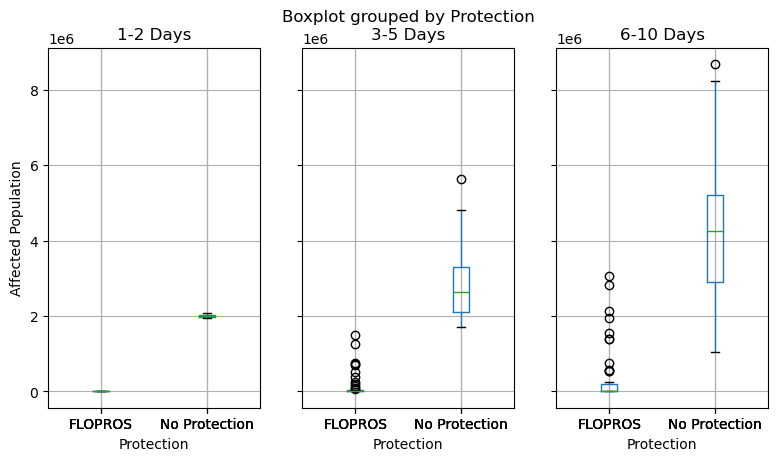

In [24]:
df_impacts = pd.concat(
    [
        pd.DataFrame.from_records(
            {idx[0]: imp.at_event for idx, imp in impact_series.items()}
            | {"Protection": "No Protection"}
        ),
        pd.DataFrame.from_records(
            {idx[0]: imp.at_event for idx, imp in impact_series_flopros.items()}
            | {"Protection": "FLOPROS"}
        ),
    ]
)
axes = df_impacts.boxplot(
    column=["1-2 Days", "3-5 Days", "6-10 Days"],
    by="Protection",
    figsize=(9, 4.8),
    layout=(1, 3),
)
axes[0].set_ylabel("Affected Population")


(100.0, 12782966.183958594)

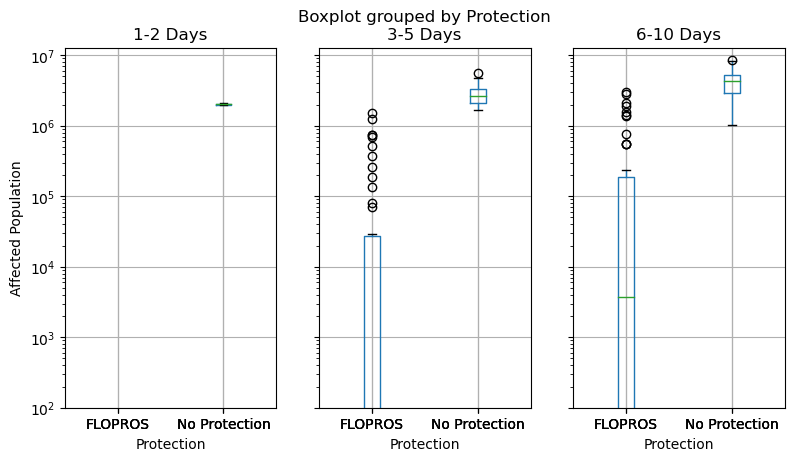

In [30]:
axes = df_impacts.boxplot(
    column=["1-2 Days", "3-5 Days", "6-10 Days"],
    by="Protection",
    figsize=(9, 4.8),
    layout=(1, 3),
)
axes[0].set_ylabel("Affected Population")
axes[0].set_yscale("log")
axes[0].set_ylim(bottom=1e2)
